In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [3]:
# Get the current directory
current_dir = os.getcwd()

# Change directory to the parent directory (diss)
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
os.chdir(parent_dir)

# Append the parent directory to the system path (optional, if you want to add it to the import path)
sys.path.append(parent_dir)

# Print the new current working directory to confirm the change
print(f"Changed directory to: {os.getcwd()}")

Changed directory to: /Users/aneeshussain/Code/diss


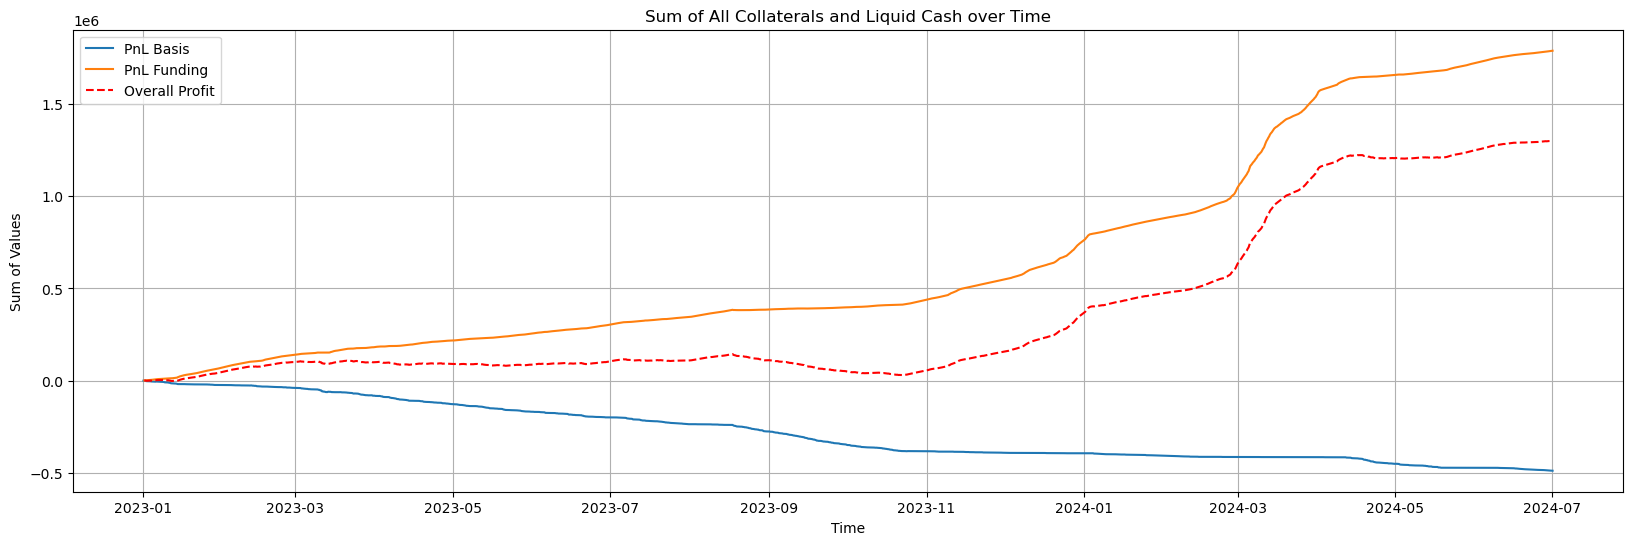

In [7]:
filepath1 = './data/logging/collateral_values_log.csv'
filepath2 = './data/logging/funding_payments_log.csv'

df1 = pd.read_csv(filepath1)
df2 = pd.read_csv(filepath2)

df1['time'] = pd.to_datetime(df1['time'])
df2['time'] = pd.to_datetime(df2['time'])

# Set the 'time' column as the index for easier plotting
df1.set_index('time', inplace=True)
df2.set_index('time', inplace=True)

# # Select the columns representing the collaterals
# collateral_columns = [
#     'binance_btc_collateral', 'binance_eth_collateral', 'binance_liquid_cash', 
#     'okx_btc_collateral', 'okx_eth_collateral', 'okx_liquid_cash', 
#     'bybit_btc_collateral', 'bybit_eth_collateral', 'bybit_liquid_cash'
# ]

# # Calculate the sum of all collaterals for each time step (total portfolio value)
# df1['total_collateral'] = df1[collateral_columns].sum(axis=1)

# # Calculate the percentage of each collateral relative to the total portfolio value
# for col in collateral_columns:
#     df1[col + '_pct'] = df1[col] / df1['total_collateral'] * 100

# # Increase plot size to make the bars more readable
# plt.figure(figsize=(12, 6))

# # Plot a stacked bar chart for each collateral over time
# df1[[col + '_pct' for col in collateral_columns]].plot(kind='bar', stacked=True, ax=plt.gca(), width=1)

# # Reduce the number of x-ticks to avoid crowding
# plt.xticks(ticks=range(0, len(df1.index), 10), labels=df1.index[::10].strftime('%Y-%m-%d'), rotation=45)

# # Add gridlines for better readability
# plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# # Customize the plot
# plt.xlabel('Time')
# plt.ylabel('Portfolio Weighting (%)')
# plt.title('Portfolio Weighting of Collaterals Over Time')
# plt.legend(title='Collaterals', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot
# plt.tight_layout()


df1['sum_all_values'] = df1.sum(axis=1)
df1['pnl_basis'] = df1['sum_all_values'] - 10000000

funding_payment_sums = df2.groupby('time')['funding payment'].sum()
funding_payment_cumsum = funding_payment_sums.cumsum()

aligned_funding_cumsum, aligned_pnl_basis = funding_payment_cumsum.align(df1['pnl_basis'], join='inner')
overall_profit = aligned_funding_cumsum + aligned_pnl_basis

pnl_sums = df2.groupby('time')['pnl'].sum()
pnl_cumsum = pnl_sums.cumsum()

# Plot the sum at each timestamp
plt.figure(figsize=(20, 6))
plt.plot(df1.index, df1['pnl_basis'], label='PnL Basis')
plt.plot(funding_payment_cumsum.index, funding_payment_cumsum.values, label='PnL Funding')
# plt.plot(pnl_cumsum.index, pnl_cumsum.values, label='PnL Realized')
plt.plot(overall_profit.index, overall_profit.values, label='Overall Profit', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Sum of Values')
plt.title('Sum of All Collaterals and Liquid Cash over Time')
plt.grid(True)
plt.legend()

plt.show()